In [1]:


import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import os

In [2]:
def load_texture_data_with_stats(image_folder):
    data = []
    labels = []
    
    for texture_name in os.listdir(image_folder):
        texture_path = os.path.join(image_folder, texture_name)
        
        if os.path.isdir(texture_path):
            for image_file in os.listdir(texture_path):
                image_path = os.path.join(texture_path, image_file)
                
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    features = extract_histogram_features(image)
                    data.append(features)
                    labels.append(texture_name)
    
    return np.array(data), np.array(labels)

In [3]:
def compute_histogram(gray_image, bins=256):
    hist = cv2.calcHist([gray_image], [0], None, [bins], [0, 256])
    hist = hist.flatten()
    hist = hist / hist.sum()
    
    values = np.arange(bins)
    features = {}
    
    # 1. Mean - средняя яркость
    features['mean'] = np.sum(hist * values)
    
    # 2. Standard Deviation - контрастность
    variance = np.sum(hist * (values - features['mean'])**2)
    features['std'] = np.sqrt(variance)
    
    # 3. Skewness - смещение распределения
    if features['std'] > 0:
        features['skewness'] = np.sum(hist * ((values - features['mean']) / features['std'])**3)
    else:
        features['skewness'] = 0
    
    # 4. Kurtosis - "острота" распределения
    if features['std'] > 0:
        features['kurtosis'] = np.sum(hist * ((values - features['mean']) / features['std'])**4) - 3
    else:
        features['kurtosis'] = -3
    
    # 5. Entropy - мера неопределенности/сложности текстуры
    non_zero_probs = hist[hist > 0]
    features['entropy'] = -np.sum(non_zero_probs * np.log2(non_zero_probs))
    
    # 6. Quartiles - 25%, 50%, 75%
    cumulative_hist = np.cumsum(hist)
    features['q1'] = np.argmax(cumulative_hist >= 0.25) 
    features['q2'] = np.argmax(cumulative_hist >= 0.5)  
    features['q3'] = np.argmax(cumulative_hist >= 0.75) 
    
    # 7. Min/Max - диапазон яркостей
    non_zero_bins = np.where(hist > 0)[0]
    if len(non_zero_bins) > 0:
        features['min'] = non_zero_bins[0]
        features['max'] = non_zero_bins[-1]
    else:
        features['min'] = 0
        features['max'] = 255
    
    return features, hist

In [4]:
def extract_histogram_features(gray_image, bins=256):
    hist = None
    stats_dict, hist = compute_histogram(gray_image, bins)
    
    features = [
        stats_dict['mean'],
        stats_dict['std'],
        stats_dict['skewness'],
        stats_dict['kurtosis'],
        stats_dict['entropy'],
        stats_dict['q1'],
        stats_dict['q2'], 
        stats_dict['q3'],
        stats_dict['min'],
        stats_dict['max']
    ]
    
    return np.array(features)

In [5]:
image_folder = "C:\\Users\\user\\Downloads\\kth_tips_grey_200x200\\KTH_TIPS\\"
data, labels = load_texture_data_with_stats(image_folder)

print(f"Размер данных: {data.shape}") 
print(f"Количество классов: {len(np.unique(labels))}")

Размер данных: (810, 10)
Количество классов: 10


In [25]:
def example_plot_texture(image_folder, num_examples):
    texture_folders = [f for f in os.listdir(image_folder)]
    
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 6 * num_examples))
    
    for i in range(min(num_examples, len(texture_folders))):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)
        
        image_files = [f for f in os.listdir(texture_path)]
        image_path = os.path.join(texture_path, image_files[3])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        features, hist = compute_histogram(image)
        
        # --- 1. Гистограмма (верх слева)
        axes[i, 0].bar(range(256), hist, alpha=0.7, color='red')
        axes[i, 0].set_title(f'Histogram — {texture_name}', fontsize=12, fontweight='bold')
        axes[i, 0].set_xlabel("Intensity")
        axes[i, 0].set_ylabel("Frequency")
        
        # --- 2. Текст характеристик (верх справа)
        metrics_text = (
            f"Brightness (Mean): {features['mean']:.1f}\n"
            f"Contrast (Std): {features['std']:.1f}\n"
            f"Asymmetry (Skewness): {features['skewness']:.3f}\n"
            f"Kurtosis (Peak): {features['kurtosis']:.3f}\n"
            f"Entropy: {features['entropy']:.3f}\n"
            f"Range: {features['min']}–{features['max']}"
        )
        axes[i, 1].text(
            0.05, 0.9, metrics_text,
            transform=axes[i, 1].transAxes,
            fontsize=11, va='top'
        )
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Texture Features", fontsize=12, fontweight='bold')
        
        # --- 3. Изображение текстуры (нижний блок)
        axes[i, 2].imshow(image, cmap='hot')
        axes[i, 2].set_title("Texture Image", fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


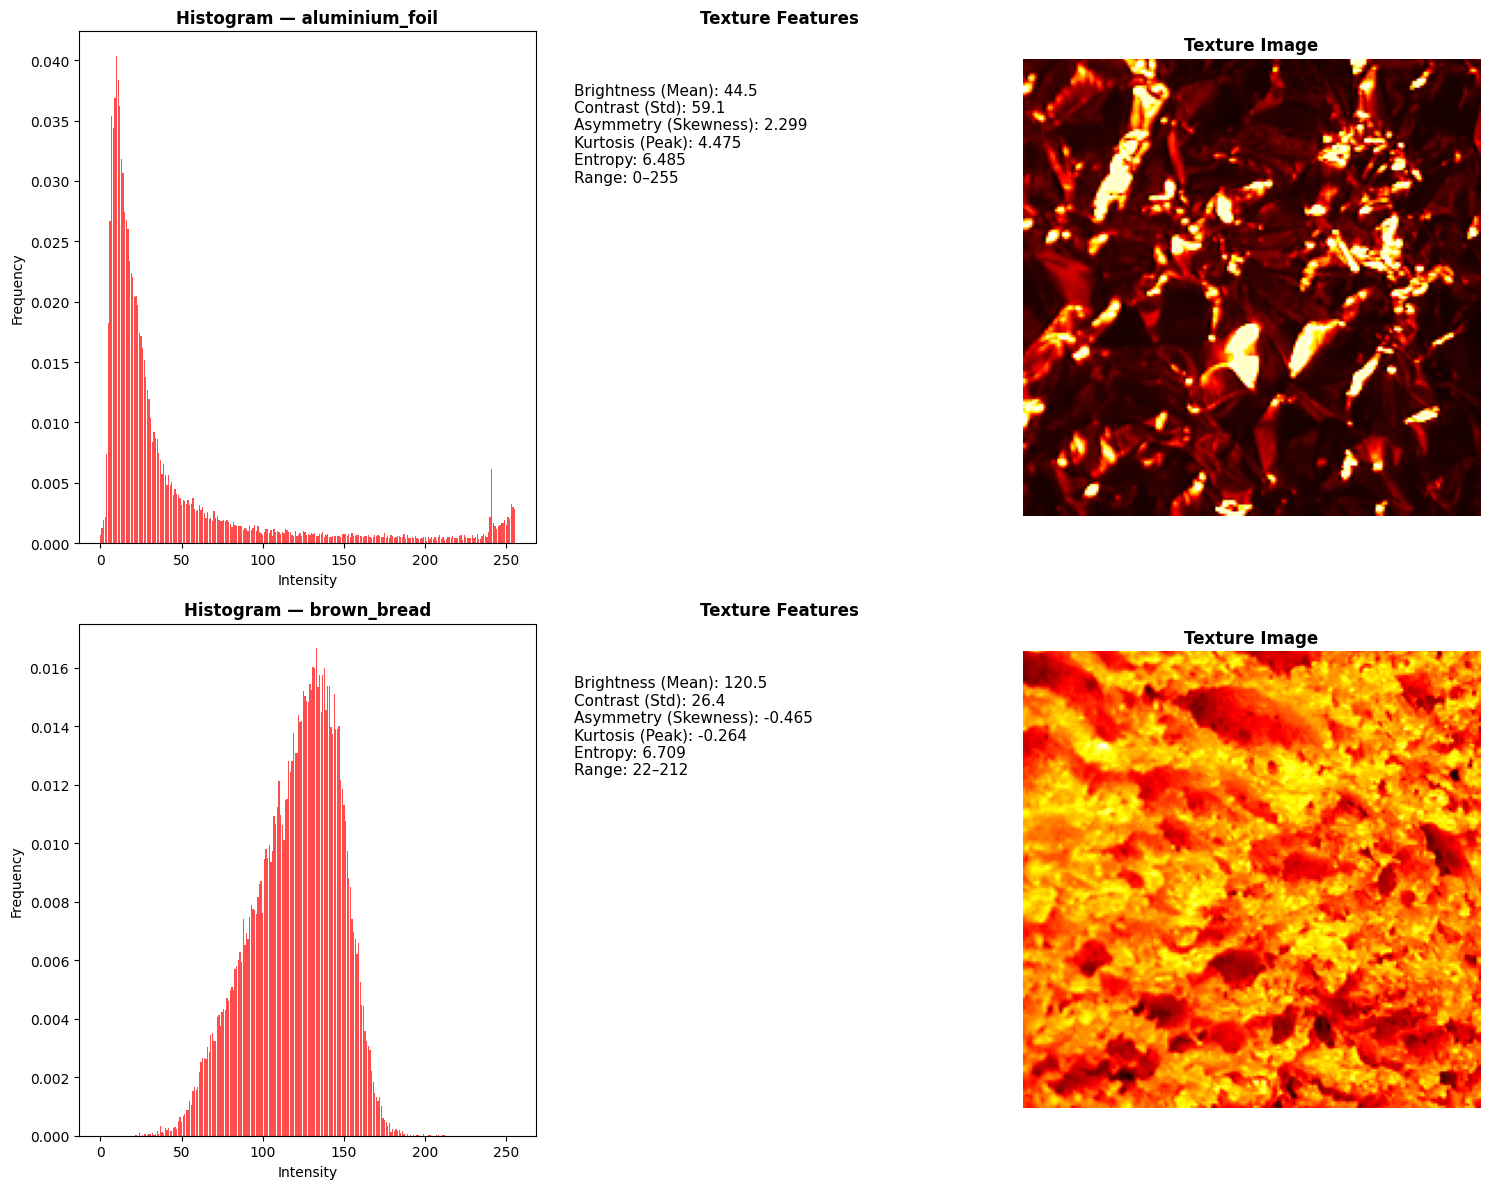

In [26]:
example_plot_texture(image_folder, num_examples=2)

In [8]:
def example_plot_laws(image_folder, num_examples=3):
    texture_folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]
    
    fig, axes = plt.subplots(num_examples, 2, figsize=(12, 4*num_examples))
    
    for i in range(min(num_examples, len(texture_folders))):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)
        
        image_files = [f for f in os.listdir(texture_path)]
        
        image_path = os.path.join(texture_path, image_files[5])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        features, names = laws_texture_features(image)
        
        # 1. Исходное изображение
        axes[i, 0].imshow(image, cmap='cool')
        axes[i, 0].set_title(f'Texture: {texture_name}')
        axes[i, 0].axis('off')
        
        # 2. Топ-5 фильтров как горизонтальная диаграмма
        top_indices = np.argsort(features)[-5:][::-1]
        top_features = [features[idx] for idx in top_indices]
        top_names = [names[idx] for idx in top_indices]
        
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
        bars = axes[i, 1].barh(top_names, top_features, color=colors, alpha=0.8, edgecolor='black')
        
        # Добавляем значения на диаграмму
        for bar, value in zip(bars, top_features):
            axes[i, 1].text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                          f'{value:.4f}', ha='left', va='center', fontweight='bold')
        
        axes[i, 1].set_title('Top 5 Laws Filters')
        axes[i, 1].set_xlabel('Energy Value')
        axes[i, 1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

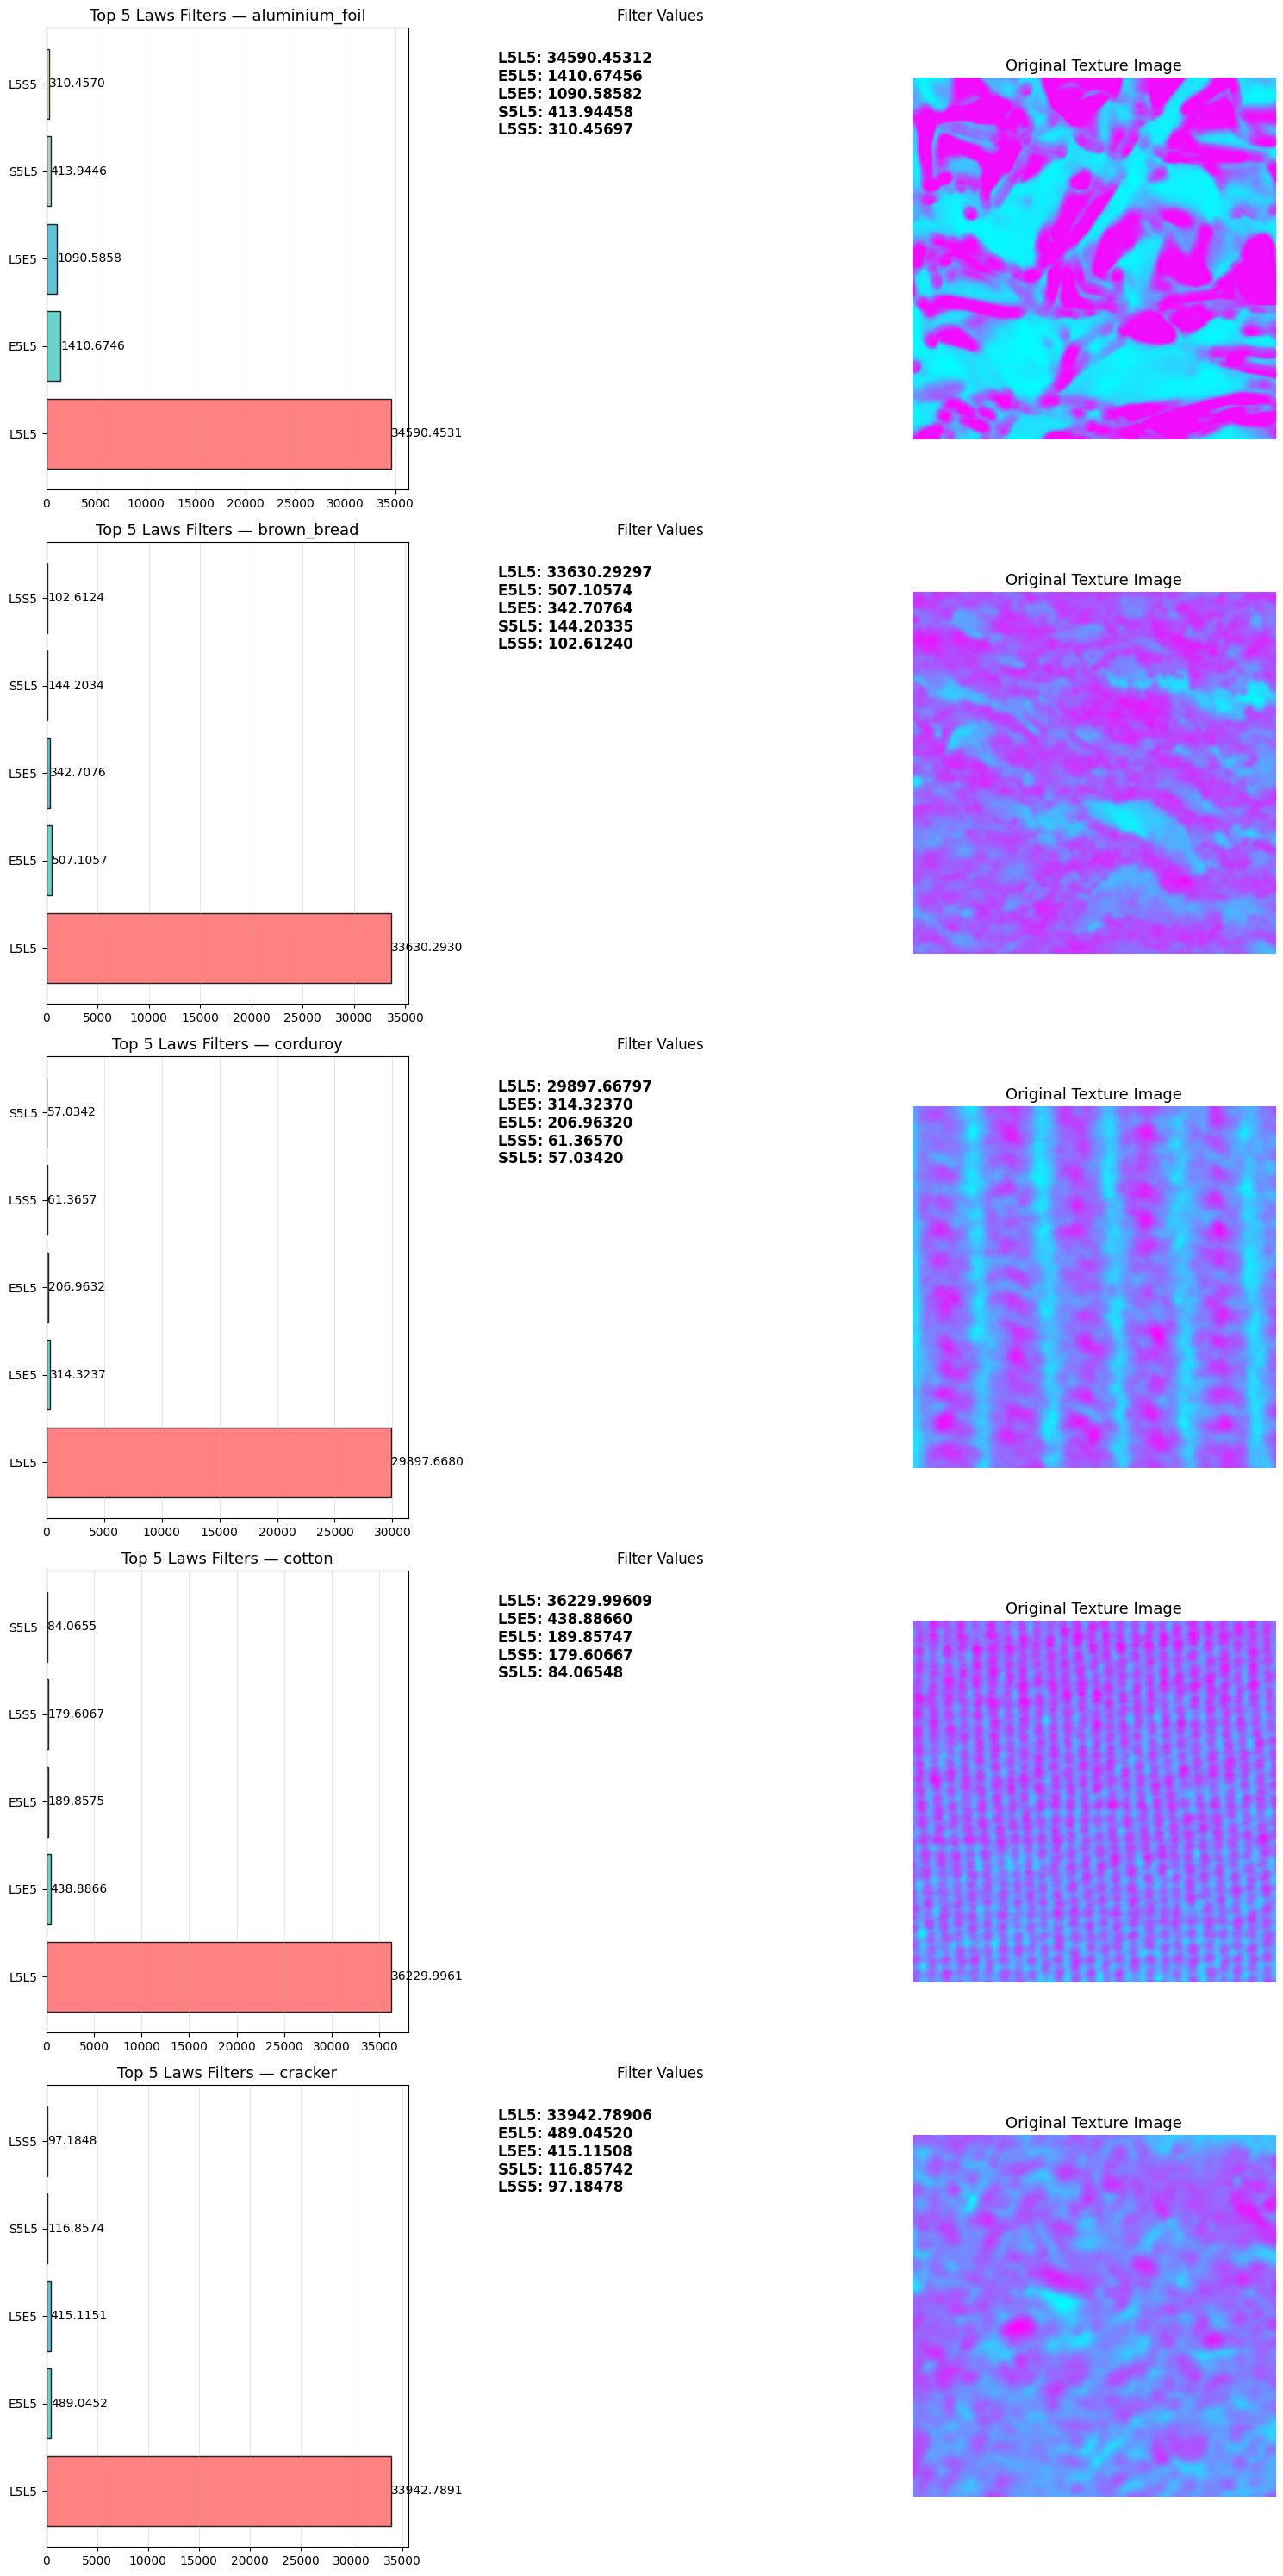

In [29]:
def example_plot_laws(image_folder, num_examples=3):
    texture_folders = [
        f for f in os.listdir(image_folder)
        if os.path.isdir(os.path.join(image_folder, f))
    ]

    num_examples = min(num_examples, len(texture_folders))
    
    # 1 строка (гистограмма + таблица), 1 строка (картинка)
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 6 * num_examples))

    if num_examples == 1:
        axes = np.array([axes])

    for i in range(num_examples):

        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)

        image_files = [
            f for f in os.listdir(texture_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
        ]
        if not image_files:
            continue

        image_path = os.path.join(texture_path, image_files[0])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        # === 1. Вычисляем признаки Laws ===
        features = extract_laws_features(image)
        
        # === 2. Находим Top-5 фильтров ===
        top_indices = np.argsort(features)[-5:][::-1]
        top_features = [features[idx] for idx in top_indices]
        top_names    = [laws_names[idx] for idx in top_indices]

        # -----------------------
        # ВЕРХНИЕ ДВА СТОЛБЦА
        # -----------------------

        # — 2.1 Горизонтальная диаграмма
        ax_hist = axes[i, 0]
        bars = ax_hist.barh(top_names, top_features,
                            color=['#FF6B6B', '#4ECDC4', '#45B7D1',
                                   '#96CEB4', '#FFEAA7'],
                            alpha=0.85, edgecolor='black')
        ax_hist.set_title(f"Top 5 Laws Filters — {texture_name}", fontsize=13)
        ax_hist.grid(True, axis='x', alpha=0.3)

        # подписи значений
        for bar, val in zip(bars, top_features):
            ax_hist.text(bar.get_width() + 0.001,
                         bar.get_y() + bar.get_height()/2,
                         f"{val:.4f}",
                         va="center", ha="left", fontsize=10)

        # — 2.2 Таблица значений
        ax_text = axes[i, 1]
        txt = "\n".join(
            f"{nm}: {val:.5f}"
            for nm, val in zip(top_names, top_features)
        )
        ax_text.text(0.05, 0.95, txt, va="top", ha="left",
                     fontsize=12, fontweight='bold')
        ax_text.axis("off")
        ax_text.set_title("Filter Values")

        # -----------------------
        # НИЖНИЙ СТОЛБЕЦ — КАРТИНКА
        # -----------------------
        ax_img = axes[i, 2]
        ax_img.imshow(image, cmap='cool')
        ax_img.set_title("Original Texture Image", fontsize=13)
        ax_img.axis('off')

    plt.tight_layout()
    plt.show()


# 5. Вызов (image_folder у тебя уже был определён выше)
example_plot_laws(image_folder, num_examples=5)


In [28]:

import numpy as np

def compute_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=32):
    """
    Вычисление GLCM-признаков БЕЗ skimage.
    image  : 2D numpy-массив (grayscale)
    levels : число уровней квантования (по умолчанию 32)
    distances, angles : список расстояний и углов для GLCM
    Возвращает вектор признаков: [contrast, dissimilarity, homogeneity, energy, correlation]
    """
    # --- 1. Квантование интенсивностей ---
    img = image.astype(np.float32)
    img_q = (img / (256 / levels)).astype(np.int32)
    img_q[img_q < 0] = 0
    img_q[img_q >= levels] = levels - 1

    # --- 2. Строим суммарную матрицу совместной встречаемости ---
    glcm = np.zeros((levels, levels), dtype=np.float64)

    h, w = img_q.shape

    # соответствие углов смещениям (dy, dx)
    angle_to_offset = {}
    for a in angles:
        # угол считаем в радианах
        if np.isclose(a, 0):
            angle_to_offset[a] = (0, 1)        # вправо
        elif np.isclose(a, np.pi/4):
            angle_to_offset[a] = (-1, 1)       # вверх-вправо
        elif np.isclose(a, np.pi/2):
            angle_to_offset[a] = (-1, 0)       # вверх
        elif np.isclose(a, 3*np.pi/4):
            angle_to_offset[a] = (-1, -1)      # вверх-влево
        else:
            # на всякий случай общее приближение
            dy = -int(round(np.sin(a)))
            dx =  int(round(np.cos(a)))
            angle_to_offset[a] = (dy, dx)

    for d in distances:
        for a in angles:
            dy, dx = angle_to_offset[a]
            dy *= d
            dx *= d

            # в зависимости от смещения ограничиваем диапазон
            if dy >= 0:
                y_range = range(0, h - dy)
            else:
                y_range = range(-dy, h)

            if dx >= 0:
                x_range = range(0, w - dx)
            else:
                x_range = range(-dx, w)

            for y in y_range:
                for x in x_range:
                    i = img_q[y, x]
                    j = img_q[y + dy, x + dx]
                    glcm[i, j] += 1.0

    # --- 3. Нормировка ---
    total = glcm.sum()
    if total > 0:
        P = glcm / total
    else:
        P = glcm  # всё нули – странный случай, но пусть так

    # --- 4. Вычисляем признаки ---

    # индексы i,j в виде сетки
    i_idx, j_idx = np.indices((levels, levels))

    # Contrast: Σ P(i,j)*(i-j)^2
    contrast = np.sum(P * (i_idx - j_idx) ** 2)

    # Dissimilarity: Σ P(i,j)*|i-j|
    dissimilarity = np.sum(P * np.abs(i_idx - j_idx))

    # Homogeneity: Σ P(i,j)/(1 + (i-j)^2)
    homogeneity = np.sum(P / (1.0 + (i_idx - j_idx) ** 2))

    # Energy: Σ P(i,j)^2
    energy = np.sum(P ** 2)

    # Correlation:
    # px(i) = Σ_j P(i,j), py(j) = Σ_i P(i,j)
    px = P.sum(axis=1)
    py = P.sum(axis=0)
    # средние
    mu_x = np.sum(px * np.arange(levels))
    mu_y = np.sum(py * np.arange(levels))
    # дисперсии
    sigma_x = np.sqrt(np.sum(px * (np.arange(levels) - mu_x) ** 2))
    sigma_y = np.sqrt(np.sum(py * (np.arange(levels) - mu_y) ** 2))

    if sigma_x > 0 and sigma_y > 0:
        correlation = np.sum(
            ((i_idx - mu_x) * (j_idx - mu_y) * P)
        ) / (sigma_x * sigma_y)
    else:
        correlation = 0.0

    features = np.array([
        contrast,
        dissimilarity,
        homogeneity,
        energy,
        correlation
    ], dtype=np.float32)

    return features


In [11]:
import numpy as np
import cv2

def laws_texture_features(image, normalize=True):
    L5 = np.array([1,  4,  6,  4,  1])   # Level (усреднение)
    E5 = np.array([-1, -2,  0,  2,  1])  # Edge (края)
    S5 = np.array([-1,  0,  2,  0, -1])  # Spot (пятна)
    W5 = np.array([-1,  2,  0, -2,  1])  # Wave (волны)
    R5 = np.array([1,  -4,  6, -4,  1])  # Ripple (рябь)
    
    masks_1d = [L5, E5, S5, W5, R5]
    masks_names = ['L5', 'E5', 'S5', 'W5', 'R5']
    
    filters_2d = []
    filter_names = []
    
    for i, mask1 in enumerate(masks_1d):
        for j, mask2 in enumerate(masks_1d):
            kernel = np.outer(mask1, mask2)
            filters_2d.append(kernel)
            filter_names.append(f"{masks_names[i]}{masks_names[j]}")
    
    features = []
    feature_names = []
    
    for kernel, name in zip(filters_2d, filter_names):
        filtered = cv2.filter2D(image.astype(np.float32), -1, kernel)
        energy = np.mean(filtered ** 2)
        features.append(energy)
        feature_names.append(f"laws_{name}")
    
    features = np.array(features)
    
    if normalize and np.sum(features) > 0:
        features = features / np.sum(features)
    
    return features, feature_names
def example_plot_glcm(image_folder, num_examples=3):
    texture_folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]
    
    for i in range(min(num_examples, len(texture_folders))):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)
        
        image_files = [f for f in os.listdir(texture_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(image_files) > 2:
            image_path = os.path.join(texture_path, image_files[2])
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is not None:
                features = compute_glcm_features(image)
                
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 2, 1)
                plt.imshow(image, cmap='viridis')
                plt.title(f'Texture: {texture_name}')
                plt.axis('off')
                
                plt.subplot(1, 2, 2)
                
                glcm_names = ['Contrast', 'Homogeneity', 'Energy', 'Correlation', 'Dissimilarity']
                colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFD700', '#FF99CC']
                
                # Создаем столбчатую диаграмму
                bars = plt.bar(glcm_names, features[:5], color=colors, alpha=0.8, edgecolor='black')
                
                # Добавляем значения на столбцы
                for bar, value in zip(bars, features[:5]):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                            f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
                
                plt.title('GLCM Texture Features')
                plt.ylabel('Feature Value')
                plt.xticks(rotation=45)
                plt.grid(True, alpha=0.3, axis='y')
                
                plt.tight_layout()
                plt.show()

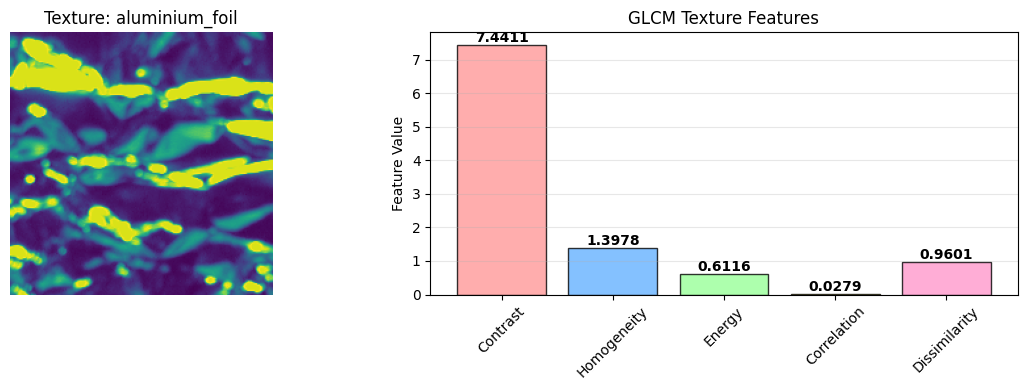

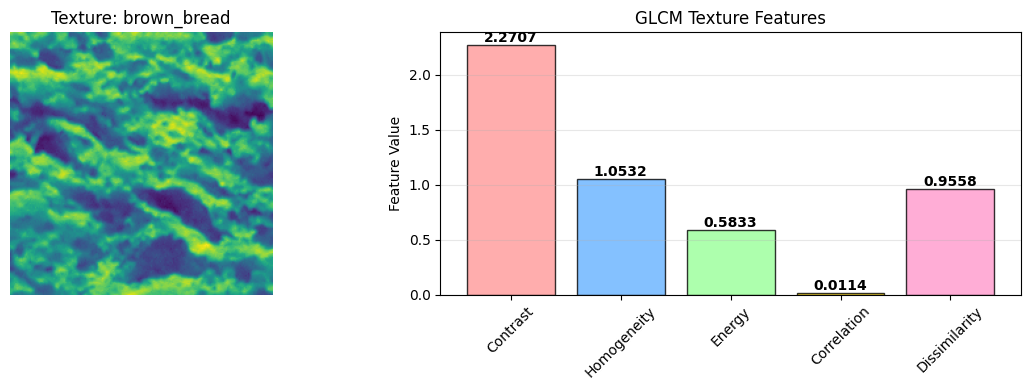

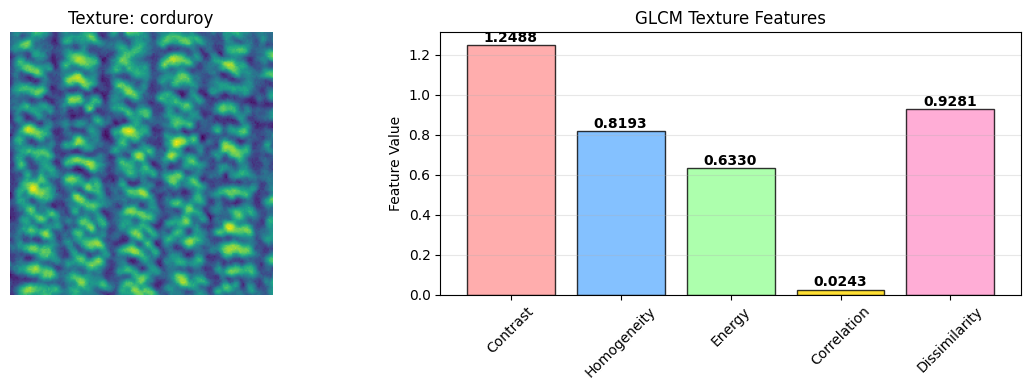

In [12]:
example_plot_glcm(image_folder, num_examples=3)

In [13]:
image_paths = []
for class_folder in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_folder)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, file))

print(f"Найдено {len(image_paths)} изображений")

Найдено 810 изображений


In [14]:
X_hist = []  
X_laws = []  
X_glcm = []  
y = []      

for i, path in enumerate(image_paths):
    if i % 50 == 0:
        print(f"Обработано {i}/{len(image_paths)} изображений")
    
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
    
    hist_features    = extract_histogram_features(image)  
    laws_features, _ = laws_texture_features(image)    
    glcm_features    = compute_glcm_features(image)       
    
    X_hist.append(hist_features)
    X_laws.append(laws_features)
    X_glcm.append(glcm_features)
    
    label = os.path.basename(os.path.dirname(path))
    y.append(label)

X_hist = np.array(X_hist)
X_laws = np.array(X_laws) 
X_glcm = np.array(X_glcm)
y = np.array(y)

print(f"Размер данных: {X_hist.shape}")
print(f"Количество классов: {len(np.unique(y))}")

le = LabelEncoder()
y_encoded = le.fit_transform(y)

methods = {
    'Histogram': X_hist,
    'Laws': X_laws, 
    'GLCM': X_glcm
}

models = {
    'kNN': KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    'SVM': SVC(kernel='rbf', random_state=42),  
    'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=10)
}

Обработано 0/810 изображений
Обработано 50/810 изображений
Обработано 100/810 изображений
Обработано 150/810 изображений
Обработано 200/810 изображений
Обработано 250/810 изображений
Обработано 300/810 изображений
Обработано 350/810 изображений
Обработано 400/810 изображений
Обработано 450/810 изображений
Обработано 500/810 изображений
Обработано 550/810 изображений
Обработано 600/810 изображений
Обработано 650/810 изображений
Обработано 700/810 изображений
Обработано 750/810 изображений
Обработано 800/810 изображений
Размер данных: (810, 10)
Количество классов: 10


In [15]:
trained_models = {}

for method_name, X in methods.items():
    print(f"\n МЕТОД: {method_name.upper()}")
    print("=" * 40)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    method_models = {}
    
    for model_name, model_template in models.items():
        if model_name == 'kNN':
            model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
        elif model_name == 'SVM':
            model = SVC(kernel='rbf', random_state=42)
        elif model_name == 'DecisionTree':
            model = DecisionTreeClassifier(random_state=42, max_depth=10)
        
        if model_name == 'SVM':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            method_models[model_name] = (model, scaler)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            method_models[model_name] = model
        
        accuracy = np.mean(y_pred == y_test)
        print(f" {model_name}:")
        print(f"   Точность: {accuracy:.1%}")
        print(f"   Отчет:\n{classification_report(y_test, y_pred, target_names=le.classes_)}")
    
    trained_models[method_name] = method_models


 МЕТОД: HISTOGRAM
 kNN:
   Точность: 74.4%
   Отчет:
                precision    recall  f1-score   support

aluminium_foil       0.95      1.00      0.98        20
   brown_bread       0.90      0.95      0.93        20
      corduroy       0.58      0.70      0.64        20
        cotton       0.55      0.52      0.54        21
       cracker       0.83      0.71      0.77        21
         linen       0.76      0.65      0.70        20
   orange_peel       0.94      0.76      0.84        21
     sandpaper       0.39      0.35      0.37        20
        sponge       0.64      0.80      0.71        20
     styrofoam       0.91      1.00      0.95        20

      accuracy                           0.74       203
     macro avg       0.75      0.74      0.74       203
  weighted avg       0.75      0.74      0.74       203

 SVM:
   Точность: 83.7%
   Отчет:
                precision    recall  f1-score   support

aluminium_foil       0.95      1.00      0.98        20
   brown_br

In [16]:
selected_models = {
    'Histogram_kNN': trained_models['Histogram']['kNN'],  
    'Laws_Tree': trained_models['Laws']['DecisionTree'],                      
    'Laws_SVM': trained_models['Laws']['SVM']                                     
}

In [17]:
def segment_sandwich(model_info, model_name, image_path, patch_size=32, step=16, n_classes=4):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    
    h, w = image.shape
    seg_map = np.zeros((h, w), dtype=np.uint8)

    all_predictions = []
    positions = []
    
    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            patch = image[y:y+patch_size, x:x+patch_size]
            
            if 'Histogram' in model_name:
                features = extract_histogram_features(patch)
            elif 'Laws' in model_name:
                features, _ = laws_texture_features(patch)
            elif 'GLCM' in model_name:
                features = compute_glcm_features(patch)
            
            if isinstance(model_info, tuple):  
                model, scaler = model_info
                features_scaled = scaler.transform(features.reshape(1, -1))
                pred_class = model.predict(features_scaled)[0]
            else:  
                model = model_info
                pred_class = model.predict(features.reshape(1, -1))[0]
            
            seg_map[y:y+patch_size, x:x+patch_size] = pred_class
            all_predictions.append(pred_class)
            positions.append((y, x))

    unique, counts = np.unique(all_predictions, return_counts=True)
    
    top_classes = unique[np.argsort(counts)[-n_classes:]]
    
    seg_map_filtered = np.zeros_like(seg_map)
    
    for i, class_id in enumerate(top_classes):
        seg_map_filtered[seg_map == class_id] = i
    
    mask_not_in_top = ~np.isin(seg_map, top_classes)
    if np.any(mask_not_in_top):
        seg_map_filtered[mask_not_in_top] = 1 
    
    print(f"Уникальные классы после фильтрации: {np.unique(seg_map_filtered)}")
    
    return seg_map_filtered

Обрабатываем: Histogram_kNN
Уникальные классы после фильтрации: [0 1 2 3]
Успешно
Обрабатываем: Laws_Tree
Уникальные классы после фильтрации: [0 1 2 3]
Успешно
Обрабатываем: Laws_SVM
Уникальные классы после фильтрации: [0 1 2 3]
Успешно


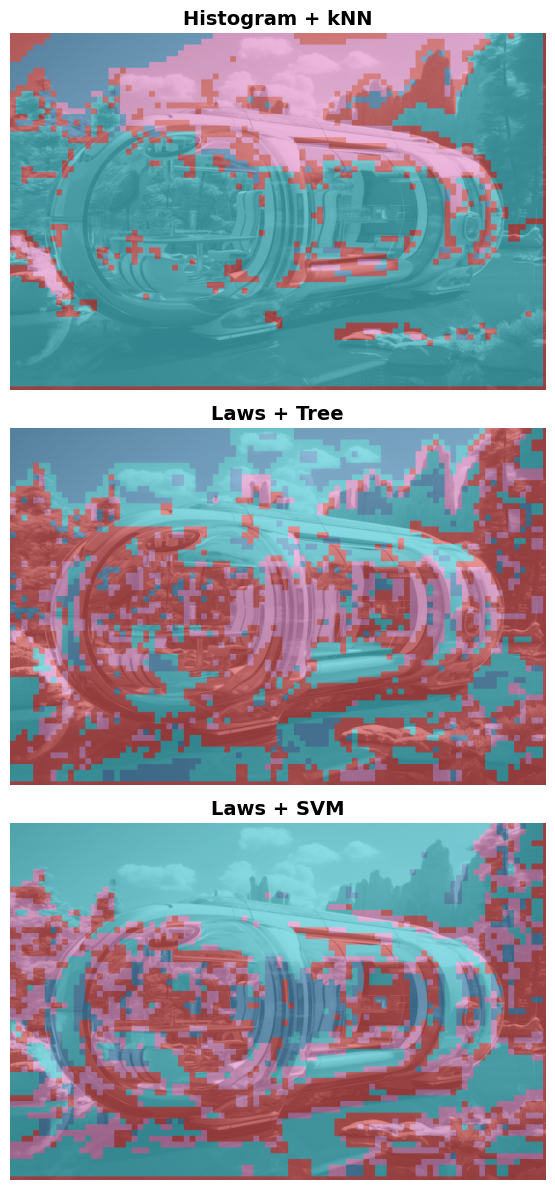

In [24]:
image_path = "Gfd.jpg"
original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if original_img is not None:
    seg_maps = []
    model_names = []
    
    for model_name, model_info in selected_models.items():
        print(f"Обрабатываем: {model_name}")
        
        seg_result = segment_sandwich(model_info, model_name, image_path, patch_size=16, step=8)
        
        if seg_result is not None:
            seg_maps.append(seg_result)
            model_names.append(model_name)
            print(f"Успешно")
        else:
            print(f"Ошибка")
    
    if seg_maps:
        fig, axes = plt.subplots(3, 1, figsize=(8, 12))  
        
        for i, (seg_map, model_name) in enumerate(zip(seg_maps, model_names)):
            if 'Histogram' in model_name:
                method = 'Histogram'
                model_type = 'kNN'
            elif 'Laws' in model_name:
                method = 'Laws'
                if 'Tree' in model_name:
                    model_type = 'Tree'
                else:
                    model_type = 'SVM'
            
            axes[i].imshow(original_img, cmap='gray', alpha=0.7)
            axes[i].imshow(seg_map, cmap='tab10', alpha=0.5)
            axes[i].set_title(f'{method} + {model_type}', fontsize=14, fontweight='bold')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

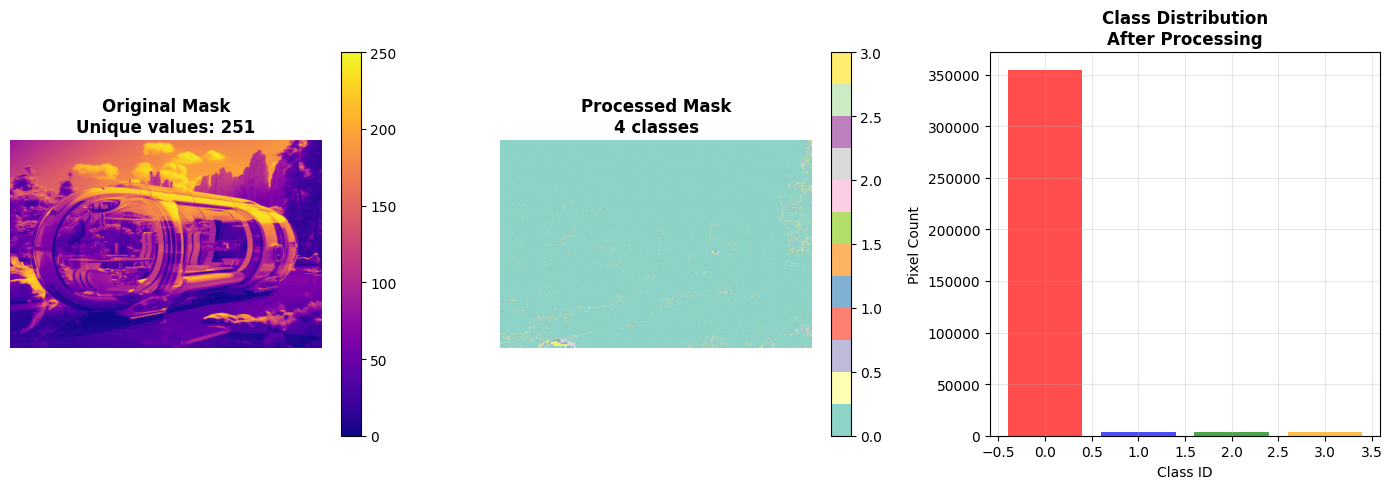

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def keep_top_colors(mask, n_colors=4):  
    mask = np.asarray(mask)  # на всякий случай приводим к numpy
    
    unique, counts = np.unique(mask, return_counts=True)
    sorted_indices = np.argsort(-counts)
    top_colors = unique[sorted_indices[:n_colors]]
    
    result = np.zeros_like(mask, dtype=np.uint8)
    
    for new_value, old_value in enumerate(top_colors):
        result[mask == old_value] = new_value
    
    return result


# Путь к маске
manual_mask_path = "Gfd.jpg"  # <-- тут должен быть реально существующий файл

if not os.path.exists(manual_mask_path):
    raise FileNotFoundError(f"Файл '{manual_mask_path}' не найден. Проверь путь!")

manual_mask = cv2.imread(manual_mask_path, cv2.IMREAD_GRAYSCALE)

if manual_mask is None:
    raise ValueError(f"Не удалось прочитать '{manual_mask_path}' как изображение.")

# гарантируем числовой тип
manual_mask = manual_mask.astype(np.uint8)

fixed_manual_mask = keep_top_colors(manual_mask, n_colors=4)

plt.figure(figsize=(14, 5))

# 1. Исходная маска
plt.subplot(1, 3, 1)
plt.imshow(manual_mask, cmap='plasma')
plt.title(f'Original Mask\nUnique values: {len(np.unique(manual_mask))}', fontweight='bold')
plt.colorbar()
plt.axis('off')

# 2. Обработанная маска
plt.subplot(1, 3, 2)
plt.imshow(fixed_manual_mask, cmap='Set3')
plt.title('Processed Mask\n4 classes', fontweight='bold')
plt.colorbar()
plt.axis('off')

# 3. Гистограмма классов
plt.subplot(1, 3, 3)
unique_new, counts_new = np.unique(fixed_manual_mask, return_counts=True)
plt.bar(unique_new, counts_new, color=['red', 'blue', 'green', 'orange'], alpha=0.7)
plt.title('Class Distribution\nAfter Processing', fontweight='bold')
plt.xlabel('Class ID')
plt.ylabel('Pixel Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Запускаем сегментацию...
Уникальные классы после фильтрации: [0 1 2 3]
Предсказание: (493, 740)
Уникальные классы в предсказании: [0 1 2 3]
Классы в ручной разметке: [0 1 2 3]
Классы в предсказании: [0 1 2 3]

Точность: 37.0%
IoU по классам:
   Класс 0: 0.370
   Класс 1: 0.011
   Класс 2: 0.014
   Класс 3: 0.004


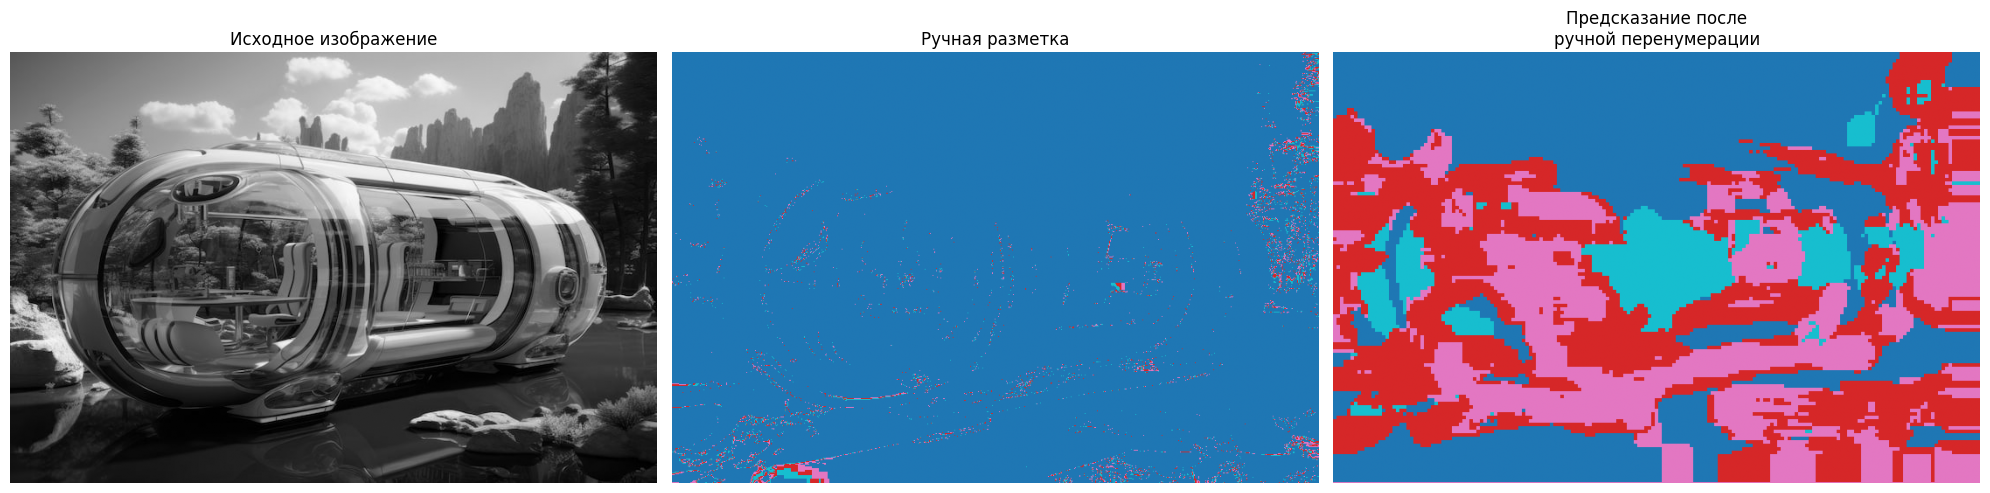

Итог: 37.0% правильных пикселей


In [23]:
from sklearn.metrics import accuracy_score, jaccard_score
def compare_simple(manual_mask, predicted_mask, model_name, original_img):
    
    predicted_resized = predicted_mask
    
    manual_classes = np.unique(manual_mask)
    pred_classes = np.unique(predicted_resized)
    
    print(f"Классы в ручной разметке: {manual_classes}")
    print(f"Классы в предсказании: {pred_classes}")
    
    class_mapping = {
        0: 3,  
        1: 2,  
        2: 1,    
        3: 0   
    }
    
    pred_mapped = predicted_resized.copy()
    for pred_class, manual_class in class_mapping.items():
        pred_mapped[predicted_resized == pred_class] = manual_class
    
    accuracy = accuracy_score(manual_mask.flatten(), pred_mapped.flatten())
    
    print(f"\nТочность: {accuracy:.1%}")
    print(f"IoU по классам:")
    
    for class_id in manual_classes:
        iou = jaccard_score(manual_mask.flatten(), pred_mapped.flatten(), 
                          average=None, labels=[class_id])[0]
        print(f"   Класс {class_id}: {iou:.3f}")
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Исходное изображение')
    axes[0].axis('off')
    
    axes[1].imshow(manual_mask, cmap='tab10')
    axes[1].set_title('Ручная разметка')
    axes[1].axis('off')
    
    axes[2].imshow(pred_mapped, cmap='tab10')
    axes[2].set_title(f'Предсказание после\nручной перенумерации')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return accuracy

image_path = "Gfd.jpg"
original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

model_name = 'Laws_SVM'
model_info = selected_models[model_name]

print("Запускаем сегментацию...")
predicted_mask = segment_sandwich(
    model_info, model_name, image_path,
    patch_size=32, step=4
)

print(f"Предсказание: {predicted_mask.shape}")
print(f"Уникальные классы в предсказании: {np.unique(predicted_mask)}")

if fixed_manual_mask is not None and predicted_mask is not None and original_img is not None:
    accuracy = compare_simple(fixed_manual_mask, predicted_mask, model_name, original_img)
    print(f"Итог: {accuracy*100:.1f}% правильных пикселей")